# Exercise 3

In [220]:
from pathlib import Path
import random
import tarfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_array, check_is_fitted

In [165]:
def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://raw.githubusercontent.com/ageron/data/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    train_path = Path("datasets/titanic/train.csv")
    test_path = Path("datasets/titanic/test.csv")
    if not train_path.is_file() or not test_path.is_file():
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return (
        pd.read_csv(train_path),
        pd.read_csv(test_path),
    )

train_raw, test_raw = load_titanic_data()

train_raw.info()
print()
test_raw.info()  
print()
print(train_raw[:3])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass 

### Notes

* 891 samples in the training set.
* Most columns are filled with non-null except:
  - Age (missing some)
  - Cabin (missing a lot)
  - Embarked (missing a couple)
* What is "Parch"?
* The test set doesn't have "Survived"... it's not very useful (for evaluating the trained model) without it. We'll have to use cross validation techniques.

In [22]:
def data_label_split(data_raw):
    y = data_raw['Survived']
    X = data_raw.drop('Survived', axis=1)
    return X, y

X_train, y_train = data_label_split(train_raw)
X_test = test_raw

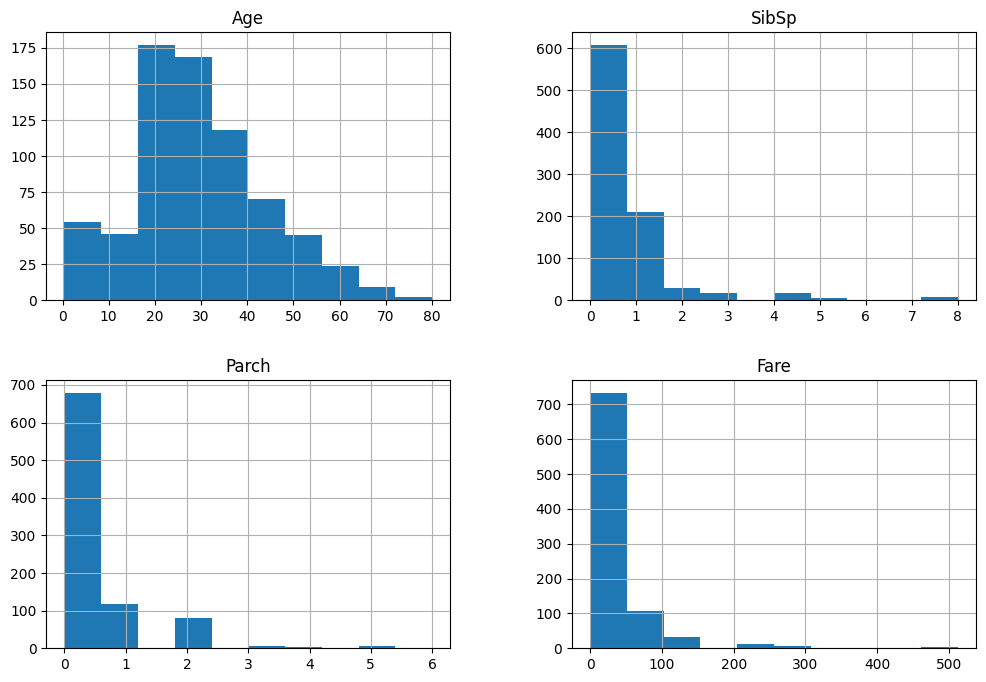

In [35]:
X_train.drop(['PassengerId', 'Pclass'], axis=1).hist(figsize=(12, 8))
plt.show()

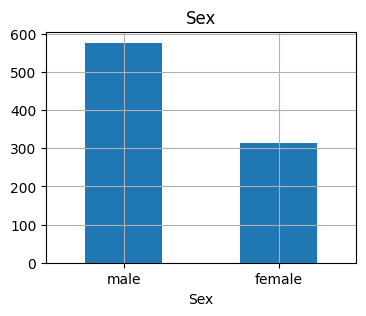

In [119]:
# We can use an category encoder (like one-hot) to encode this label.
X_train['Sex'].value_counts(dropna=False).plot.bar(rot=0, figsize=(4, 3))
plt.grid(True)
plt.title('Sex')
plt.show()

In [128]:
# We expect Cabin values to be a series of A00 style letter number combinations.
# They sometimes indicate multiple cabins like "A00 A01".
# If cabin letter is used for one of the cabins listed, the rest are also the same letter.
# Some cabins are prefixed with "F " which we break out into its own category.

def validate_cabin_breakdown(data):
    cabin_breakdown = []
    for cabin in data['Cabin']:
        values = {
            'CabinPrefixF': 'U',
            'CabinLetter': 'U',
        }
        if cabin is not np.nan:
            if cabin.startswith('F '):
                values['CabinPrefixF'] = 'T'
                cabin = cabin[2:]
            else:
                values['CabinPrefixF'] = 'F'
            parts = cabin.split()
            letter = parts[0][0]
            if letter not in 'ABCDEFGT':
                print(cabin)
            assert letter in 'ABCDEFGT'
            for part in parts[1:]:
                if part[0] != letter:
                    print(cabin)
                assert part[0] == letter
            values['CabinLetter'] = letter
        cabin_breakdown.append(values)
    return pd.DataFrame(cabin_breakdown)

cabin_breakdown = validate_cabin_breakdown(X_train)
validate_cabin_breakdown(X_test)

# We can use one-hot encoders to encode this categorical data.
cabin_breakdown = pd.DataFrame(cabin_breakdown)
cabin_breakdown.value_counts(dropna=False)

CabinPrefixF  CabinLetter
U             U              687
F             C               59
              B               47
              D               33
              E               32
              A               15
              F                9
              G                4
T             G                3
              E                1
F             T                1
Name: count, dtype: int64

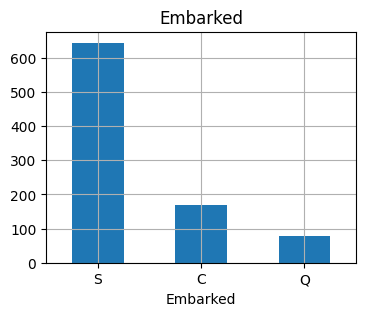

In [120]:
# We can use a categorical encoder (like one-hot) to encode this data.
X_train['Embarked'].value_counts().plot.bar(rot=0, figsize=(4, 3))
plt.grid(True)
plt.title('Embarked')
plt.show()

In [62]:
[X_train['Ticket'][random.randint(0, len(X_train) - 1)] for _ in range(20)]

['PC 17585',
 'CA. 2343',
 'PC 17611',
 '244358',
 '250651',
 '2620',
 'C 7075',
 '112050',
 'STON/O 2. 3101293',
 'SOTON/OQ 392086',
 'A.5. 18509',
 'PC 17609',
 '347082',
 '111320',
 'PC 17761',
 '350036',
 '364849',
 'PC 17485',
 '370377',
 '36928']

In [140]:
def clean_data(data):
    cabin_breakdown = validate_cabin_breakdown(data)
    out = data.copy()
    out['FareLog'] = np.log(out['Fare'] + 1.0)
    out['ParchLog'] = np.log(out['Parch'] + 1.0)
    out['SibSpLog'] = np.log(out['SibSp'] + 1.0)
    out['CabinLetter'] = cabin_breakdown['CabinLetter']
    out['CabinPrefixF'] = cabin_breakdown['CabinPrefixF']
    return out

In [241]:
num_attribs = [
    'Age',
    'FareLog',
    'ParchLog',
    'SibSpLog',
]

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_attribs = [
    'CabinLetter',
    'CabinPrefixF',
    'Embarked',
    'Pclass',
    'Sex',
]

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),  # TODO IDK if I want this?
    ('encode', OneHotEncoder(handle_unknown='ignore')),
])

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

X_train_processed = preprocessing.fit_transform(clean_data(X_train))
X_test_processed = preprocessing.transform(clean_data(X_test))

print(preprocessing.get_feature_names_out())

['num__Age' 'num__FareLog' 'num__ParchLog' 'num__SibSpLog'
 'cat__CabinLetter_A' 'cat__CabinLetter_B' 'cat__CabinLetter_C'
 'cat__CabinLetter_D' 'cat__CabinLetter_E' 'cat__CabinLetter_F'
 'cat__CabinLetter_G' 'cat__CabinLetter_T' 'cat__CabinLetter_U'
 'cat__CabinPrefixF_F' 'cat__CabinPrefixF_T' 'cat__CabinPrefixF_U'
 'cat__Embarked_C' 'cat__Embarked_Q' 'cat__Embarked_S' 'cat__Pclass_1'
 'cat__Pclass_2' 'cat__Pclass_3' 'cat__Sex_female' 'cat__Sex_male']


In [158]:
cross_val_score(KNeighborsClassifier(), X_train_processed, y_train, cv=3, n_jobs=-1)

array([0.77441077, 0.82154882, 0.83501684])

In [184]:
knn_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={
        'n_neighbors': [2, 3, 4, 5, 6, 7, 8],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [5, 10, 15, 20, 25, 30, 35, 40],
        'p': [1, 2],
    },
    cv=3,
    n_jobs=-1,
)

knn_search.fit(X_train_processed, y_train)
print(knn_search.best_params_)
cross_val_score(knn_search.best_estimator_, X_train_processed, y_train, cv=3, n_jobs=-1)

{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


array([0.77777778, 0.81818182, 0.83838384])

In [160]:
cross_val_score(SVC(), X_train_processed, y_train, cv=3, n_jobs=-1)

array([0.8013468 , 0.82491582, 0.83164983])

In [193]:
svc_search = GridSearchCV(
    SVC(),
    param_grid={
        'kernel': ['linear', 'sigmoid', 'rbf', 'poly'],
        'C': [0.5, 1.0, 1.5, 2.0, 2.5],
        'probability': [True, False],
        'decision_function_shape': ['ovo', 'ovr'],
    },
    cv=3,
    n_jobs=-1,
)

svc_search.fit(X_train_processed, y_train)
print(svc_search.best_params_)
cross_val_score(svc_search.best_estimator_, X_train_processed, y_train, cv=3, n_jobs=-1)

{'C': 2.0, 'decision_function_shape': 'ovo', 'kernel': 'poly', 'probability': True}


array([0.8013468 , 0.82154882, 0.84848485])

In [161]:
cross_val_score(SGDClassifier(), X_train_processed, y_train, cv=3, n_jobs=-1)

array([0.61952862, 0.71717172, 0.79461279])

In [203]:
sgd_search = GridSearchCV(
    SGDClassifier(),
    param_grid={
        'loss': [
            'hinge',
            'log_loss',
            'modified_huber',
            'squared_hinge',
            'perceptron',
            'squared_error',
            'huber',
            'epsilon_insensitive',
            'squared_epsilon_insensitive',
        ],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'epsilon': [0.05, 0.10, 0.15, 0.20],
        'alpha': [0.00005, 0.0001, 0.00015, 0.0002],
        'max_iter': [100000],
    },
    cv=3,
    n_jobs=-1,
)

sgd_search.fit(X_train_processed, y_train)
print(sgd_search.best_params_)
cross_val_score(sgd_search.best_estimator_, X_train_processed, y_train, cv=3, n_jobs=-1)

{'alpha': 0.00015, 'epsilon': 0.2, 'loss': 'squared_error', 'max_iter': 100000, 'penalty': 'l1'}


array([0.7979798 , 0.76094276, 0.78451178])

In [162]:
cross_val_score(RandomForestClassifier(), X_train_processed, y_train, cv=3, n_jobs=-1)

array([0.76767677, 0.7979798 , 0.8047138 ])

In [204]:
rf_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        'criterion': [
            'gini', 'entropy', 'log_loss',
        ],
        'max_features': ['sqrt', 'log2', 2, 3, 4, 5, 6, 7, 8],
    },
    cv=3,
    n_jobs=-1,
)

rf_search.fit(X_train_processed, y_train)
print(rf_search.best_params_)
cross_val_score(rf_search.best_estimator_, X_train_processed, y_train, cv=3, n_jobs=-1)

{'criterion': 'gini', 'max_features': 6}


array([0.77441077, 0.81481481, 0.79461279])

In [227]:
# Food for thought: can I make a custom Transform class to do the data preparation?

In [251]:
best_estimator = svc_search.best_estimator_

y_test_pred = best_estimator.predict(X_test_processed)

number_of_people = len(y_test_pred)
number_of_survivors = y_test_pred.sum()
print(f'Survivor Rate: {number_of_survivors / number_of_people * 100:.2f}%')

Survivor Rate: 37.56%


In [252]:
total_people = len(y_test_pred) + len(y_train)
total_survivors = y_test_pred.sum() + y_train.sum()

print(f'Total Survivor Rate: {total_survivors / total_people * 100:.2f}%')

Total Survivor Rate: 38.12%


In [254]:
# There were 2208 passengers on the Titanic and 1501 perished.
# The actual survival rate was 32.0%, so we're off by a bit.
# Also, our dataset is not complete.